# Initial MIGAN

In [1]:
from __future__ import print_function, division


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf

import matplotlib.pyplot as plt

import sys

import numpy as np



In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 64 #28
        self.img_cols = 64 #28
        self.channels = 3 #1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes x_train as input and generates imgs
        sta_imgs = Input(shape=(self.img_shape))
        gen_imgs = self.generator(sta_imgs)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(gen_imgs)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(sta_imgs, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        # For training, we will compare the sample consecutive frames with the generated frames
#         self.sample_frame =self.train.


    def build_generator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        sta_imgs = Input(shape=(self.img_shape))
        gen_imgs = model(sta_imgs)

        return Model(sta_imgs, gen_imgs)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        
        model.summary()

        sam_imgs = Input(shape=self.img_shape)
        validity = model(sam_imgs)

        return Model(sam_imgs, validity)

    def train(self, epochs, batch_size=32 , sample_interval=30):

        # Cut and load the dataset to shape (60000,64,64,3)
        data = np.load("mnist_test_seq.npy")
        cframe1 = data[0:3]
        cframe2 = data[3:6] 
        cframe3 = data[6:9]
        cframe4 = data[9:12]
        cframe5 = data[12:15]
        cframe6 = data[15:18]
        cframes = np.concatenate((cframe1,cframe2,cframe3,cframe4,cframe5,cframe6),axis=1)
        Y_train = cframes.transpose(1,2,3,0)

        # Rescale -1 to 1
        Y_train = Y_train / 127.5 - 1.
        

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, Y_train.shape[0], batch_size) 
            sam_imgs = Y_train[idx] #For Y_train
            
            X_train = np.expand_dims(Y_train[:,:,:,0], axis=3) #For X_train
            X_train = np.concatenate((X_train,X_train,X_train),axis=3)
            sta_imgs = X_train[idx]
            
            # Generate a batch of new images
            gen_imgs = self.generator.predict(sta_imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(sam_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(sta_imgs, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)


    def sample_images(self, epoch):
        # Load data
        data = np.load("mnist_test_seq.npy")
        cframe1 = data[0:3]
        cframe2 = data[3:6] 
        cframe3 = data[6:9]
        cframe4 = data[9:12]
        cframe5 = data[12:15]
        cframe6 = data[15:18]
        cframes = np.concatenate((cframe1,cframe2,cframe3,cframe4,cframe5,cframe6),axis=1)
        Y_train = cframes.transpose(1,2,3,0)
        
        X_train = np.expand_dims(Y_train[:,:,:,0], axis=3) 
        X_train = np.concatenate((X_train,X_train,X_train),axis=3)
        
        idx = np.random.randint(0, Y_train.shape[0], 32)
        sta_imgs = X_train[idx]
        gen_imgs = self.generator.predict(sta_imgs)
        sam_imgs = Y_train[idx]

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        sam_imgs = 0.5 * sam_imgs + 0.5
        
        # Plot images

        fig = plt.figure()
        row1 = plt.subplot(2,3,1)
        plt.imshow(sam_imgs[0,:,:,0], cmap='gray')
        row1.title.set_text("Real sequence")
        plt.axis("off")
        plt.subplot(2,3,2)
        plt.imshow(sam_imgs[0,:,:,1], cmap='gray')
        plt.axis("off")
        plt.subplot(2,3,3)
        plt.imshow(sam_imgs[0,:,:,2], cmap='gray')
        plt.axis("off")

        row2 = plt.subplot(2,3,4)
        plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
        row2.title.set_text("Generated sequence")
        plt.axis("off")
        plt.subplot(2,3,5)
        plt.imshow(gen_imgs[0,:,:,1], cmap='gray')
        plt.axis("off")
        plt.subplot(2,3,6)
        plt.imshow(gen_imgs[0,:,:,2], cmap='gray')
        plt.axis("off")
        
        fig.savefig("Moving_MNIST/%d.png" % epoch)
        plt.close()


# if __name__ == '__main__':
#     gan = GAN()
#     gan.train(epochs=50000, batch_size=32, sample_interval=20)

(60000, 28, 28)

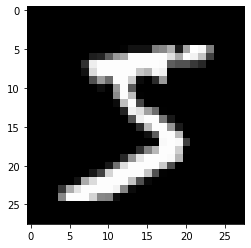

In [23]:
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1
plt.imshow(X_train[0,:,:], cmap="gray")

X_train.shape

(60000, 64, 64, 3)


<function matplotlib.pyplot.show(*args, **kw)>

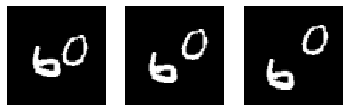

In [14]:
#plot sample images

#load data
data = np.load("mnist_test_seq.npy")
cframe1 = data[0:3]
cframe2 = data[3:6] 
cframe3 = data[6:9]
cframe4 = data[9:12]
cframe5 = data[12:15]
cframe6 = data[15:18]
cframes = np.concatenate((cframe1,cframe2,cframe3,cframe4,cframe5,cframe6),axis=1)
Y_train = cframes.transpose(1,2,3,0)
print(Y_train.shape)

    
idx = np.random.randint(0, Y_train.shape[0])
sam_imgs = Y_train[idx]


fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(sam_imgs[:,:,0], cmap='gray')
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(sam_imgs[:,:,1], cmap='gray')
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(sam_imgs[:,:,2], cmap='gray')
plt.axis("off")

plt.show
# fig.savefig("1.png")
# plt.close()


<function matplotlib.pyplot.show(*args, **kw)>

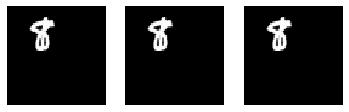

In [16]:
X_train = np.expand_dims(Y_train[:,:,:,1], axis=3)
X_train = np.concatenate((X_train,X_train,X_train),axis=3)
X_train.shape

idx = np.random.randint(0, X_train.shape[0])
sta_imgs = X_train[idx]

plt.subplot(1,3,1)
plt.imshow(sta_imgs[:,:,0], cmap='gray')
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(sta_imgs[:,:,1], cmap='gray')
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(sta_imgs[:,:,2], cmap='gray')
plt.axis("off")


plt.show


<function matplotlib.pyplot.show(*args, **kw)>

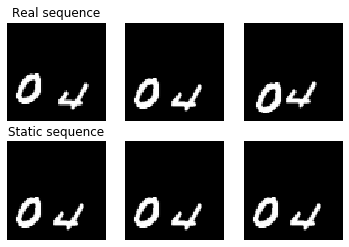

In [22]:
Y_train = np.concatenate((data[0:3],data[3:6],data[6:9],data[9:12],data[12:15],data[15:18]),axis=1).transpose(1,2,3,0)
idx = np.random.randint(0, Y_train.shape[0], 32) 
sam_imgs = Y_train[idx] #For Y_train

X_train = np.expand_dims(Y_train[:,:,:,1], axis=3) #For X_train
X_train = np.concatenate((X_train,X_train,X_train),axis=3)
sta_imgs = X_train[idx]



fig = plt.figure()
row1 = plt.subplot(2,3,1)
plt.imshow(sam_imgs[0,:,:,0], cmap='gray')
row1.title.set_text("Real sequence")
plt.axis("off")
plt.subplot(2,3,2)
plt.imshow(sam_imgs[0,:,:,1], cmap='gray')
plt.axis("off")
plt.subplot(2,3,3)
plt.imshow(sam_imgs[0,:,:,2], cmap='gray')
plt.axis("off")

row2 = plt.subplot(2,3,4)
plt.imshow(sta_imgs[0,:,:,0], cmap='gray')
row2.title.set_text("Static sequence")
plt.axis("off")
plt.subplot(2,3,5)
plt.imshow(sta_imgs[0,:,:,1], cmap='gray')
plt.axis("off")
plt.subplot(2,3,6)
plt.imshow(sta_imgs[0,:,:,2], cmap='gray')
plt.axis("off")

plt.show